## Purpose 
First model showed that using TF-IDF vectorizer and NMF decomposition led to the topics that made the most sense. 
Will re-iterate that pipeline only here, and expand analysis, for the us_pops data


In [2]:
import pickle
import numpy as np
import pandas as pd

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.feature_extraction import text

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [3]:
file = open('../../Webscraper/us_pops_raw', 'rb')
us_pops_raw = pickle.load(file)
us_pops_raw = us_pops_raw.dropna().reset_index(drop=True)
us_pops = us_pops_raw['Lyrics']

# only keep alphanumeric, remove newlines, and make everything lowercase
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
rm_newline = lambda x: re.sub("\n", ' ',x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

us_pops_nopunc = us_pops.map(alphanumeric).map(rm_newline).map(punc_lower)

In [4]:
# lemmatize. do this by turning every line into a list of words, and concat back to full lyrics
us_pops_list = us_pops_nopunc.apply(lambda x: x.split(' '))

def lemmatize(list_of_words):
    lmt = WordNetLemmatizer()
    strg = ''
    for word in list_of_words:
        lem_word = lmt.lemmatize(word)
        if len(lem_word) > 2:
            strg += lem_word + ' '
    return strg

us_pops_clean = us_pops_list.apply(lemmatize)

In [5]:
stop_words_added = text.ENGLISH_STOP_WORDS.union(['huh','woo','whoa','hey','hold','really','gotta'])

tfidf =  TfidfVectorizer(
    stop_words = stop_words_added,
    max_df = 0.2,
    min_df = 0.0005
)
Y = tfidf.fit_transform(us_pops_clean)
doc_term_matrix = pd.DataFrame(Y.toarray(), columns=tfidf.get_feature_names())

In [6]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [7]:
# topic_word = pd.DataFrame(
#     nmf_model.components_.round(3),
#     columns = tfidf.get_feature_names()
#     )
# topic_word

In [8]:
nmf_model = NMF(5, random_state = 42)
doc_topic = nmf_model.fit_transform(doc_term_matrix)

display_topics(nmf_model, tfidf.get_feature_names(), 25)


Topic  0
believe, dream, stay, friend, gone, try, forever, better, true, long, home, wrong, fall, lie, inside, leave, wish, change, thought, face, place, going, did, feeling, miss

Topic  1
nigga, bitch, shit, fuck, ayy, money, gon, real, bad, lil, hoe, big, hit, fuckin, pussy, dick, bout, drop, pop, young, damn, hot, gettin, rich, new

Topic  2
tonight, alright, waiting, tomorrow, fight, party, kiss, drink, tight, inside, dancing, touch, boo, end, leave, broken, body, holding, lovin, light, looking, jump, turn, ready, dark

Topic  3
dance, body, shake, rock, everybody, party, stop, turn, floor, play, music, round, roll, club, beat, lady, song, hot, touch, work, slow, wit, gon, hit, groove

Topic  4
remember, used, memory, forget, gave, bring, fell, saying, wish, hurt, walk, bye, picture, sad, century, yesterday, loving, lonely, alright, couldn, walking, bee, danced, walked, cried


In [9]:
doc_topic_mat = pd.DataFrame(
    doc_topic.round(3),
    columns = ['"Dreams"','"Expletives"','"Passion"','"Dance"','"Reminiscence"']
)

# re-add Song/Artist
doc_topic_mat = doc_topic_mat.join(us_pops_raw[['Song','Artist']])

In [10]:
doc_topic_mat

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist
0,0.061,0.000,0.000,0.011,0.000,Hold On,Wilson Phillips
1,0.063,0.000,0.006,0.007,0.000,It Must Have Been Love,Roxette
2,0.041,0.002,0.000,0.000,0.010,Nothing Compares 2 U,Sinéad O'Connor
3,0.019,0.011,0.002,0.017,0.001,Poison,Bell Biv DeVoe
4,0.000,0.000,0.000,0.080,0.001,Vogue,Madonna
...,...,...,...,...,...,...,...
2666,0.052,0.000,0.000,0.001,0.080,Eyes on You,Chase Rice
2667,0.039,0.000,0.006,0.056,0.000,All to Myself,Dan + Shay
2668,0.022,0.006,0.003,0.011,0.000,Boyfriend,Ariana Grande and Social House
2669,0.056,0.004,0.132,0.000,0.000,Walk Me Home,Pink


In [11]:
doc_topic_mat.sort_values('"Reminiscence"',ascending=False).head(20)

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist
49,0.000,0.000,0.000,0.000,0.588,Do You Remember,Phil Collins
212,0.000,0.000,0.000,0.000,0.581,Remember the Time,Michael Jackson
1617,0.003,0.000,0.000,0.000,0.553,Walk Away (Remember Me),Paula DeAnda featuring The D.E.Y.
398,0.000,0.000,0.000,0.000,0.534,I'll Remember,Madonna
551,0.000,0.000,0.000,0.000,0.527,You Used to Love Me,Faith Evans
1352,0.000,0.000,0.000,0.000,0.520,Remember When,Alan Jackson
288,0.000,0.000,0.000,0.000,0.504,I Will Remember You,Amy Grant
1714,0.014,0.000,0.000,0.000,0.449,I Remember,Keyshia Cole
1855,0.000,0.006,0.062,0.014,0.405,Do You Remember,Jay Sean featuring Sean Paul and Lil Jon
68,0.013,0.000,0.000,0.000,0.394,I Remember You,Skid Row


In [12]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(doc_topic_mat.iloc[:,:5])
    Sum_of_squared_distances.append(km.inertia_)

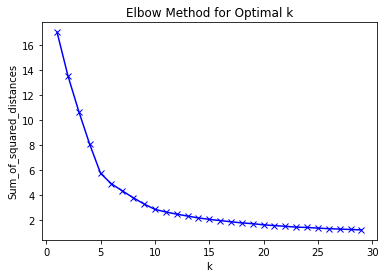

In [13]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Optimal k')
plt.show()

### Try 5, 10, or 15

In [14]:
# Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Load in the data
df = doc_topic_mat.iloc[:,:5]

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=2)
pca.fit_transform(X_std)

x_pca = pca.transform(X_std)

In [15]:
modelkmeans = KMeans(n_clusters = 15, random_state = 42)
hello = modelkmeans.fit(doc_topic_mat.iloc[:,:5])

In [16]:
labels = modelkmeans.fit_predict(doc_topic_mat.iloc[:,:5])

In [17]:
doc_topic_mat['cluster'] = labels

In [18]:
doc_topic_mat

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist,cluster
0,0.061,0.000,0.000,0.011,0.000,Hold On,Wilson Phillips,0
1,0.063,0.000,0.006,0.007,0.000,It Must Have Been Love,Roxette,0
2,0.041,0.002,0.000,0.000,0.010,Nothing Compares 2 U,Sinéad O'Connor,14
3,0.019,0.011,0.002,0.017,0.001,Poison,Bell Biv DeVoe,5
4,0.000,0.000,0.000,0.080,0.001,Vogue,Madonna,9
...,...,...,...,...,...,...,...,...
2666,0.052,0.000,0.000,0.001,0.080,Eyes on You,Chase Rice,1
2667,0.039,0.000,0.006,0.056,0.000,All to Myself,Dan + Shay,8
2668,0.022,0.006,0.003,0.011,0.000,Boyfriend,Ariana Grande and Social House,5
2669,0.056,0.004,0.132,0.000,0.000,Walk Me Home,Pink,2


In [19]:
# doc_topic_mat[doc_topic_mat['cluster'] == 0][doc_topic_mat['Artist'].str.contains('Eminem')].tail(60)

In [20]:
hip = doc_topic_mat[doc_topic_mat['cluster'] == 12]
hip.iloc[int(len(hip)//3.3):int(len(hip)//1.43)]

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist,cluster
889,0.000,0.000,0.001,0.000,0.296,I Will Remember You,Sarah McLachlan,12
1263,0.039,0.019,0.000,0.014,0.165,Put That Woman First,Jaheim,12
1466,0.037,0.000,0.000,0.018,0.211,Crazy,Gnarls Barkley,12
1754,0.000,0.014,0.000,0.067,0.139,Waking Up in Vegas,Katy Perry,12
1849,0.037,0.000,0.002,0.000,0.155,Mine,Taylor Swift,12
1869,0.063,0.000,0.000,0.000,0.126,Two Is Better Than One,Boys Like Girls featuring Taylor Swift,12
1915,0.060,0.000,0.000,0.000,0.185,Someone Like You,Adele,12
1919,0.048,0.035,0.017,0.017,0.178,The Show Goes On,Lupe Fiasco,12


In [21]:
hip = doc_topic_mat[doc_topic_mat['cluster'] == 8]
hip.iloc[int(len(hip)//3.3):int(len(hip)//1.43)].head(60)

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist,cluster
828,0.016,0.000,0.008,0.057,0.000,Kiss Me,Sixpence None the Richer,8
829,0.012,0.006,0.016,0.037,0.003,Genie in a Bottle,Christina Aguilera,8
838,0.042,0.005,0.000,0.063,0.000,All Star,Smash Mouth,8
845,0.050,0.000,0.000,0.045,0.000,Fortunate,Maxwell,8
858,0.024,0.017,0.000,0.058,0.041,Summer Girls,LFO,8
862,0.017,0.000,0.001,0.041,0.000,Mambo No. 5,Lou Bega,8
873,0.014,0.023,0.004,0.054,0.000,Miami,Will Smith,8
881,0.015,0.016,0.009,0.039,0.000,If You,Silk,8
895,0.046,0.000,0.000,0.069,0.000,Almost Doesn't Count,Brandy,8
896,0.026,0.002,0.041,0.051,0.003,Man! I Feel Like a Woman!,Shania Twain,8


In [22]:
doc_topic_mat.groupby(['cluster']).mean()*100

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence"""
cluster,,,,,
0,7.030976,0.455854,0.260244,0.554146,0.429268
1,4.305970,0.613433,0.319403,0.962687,6.205970
2,3.609412,0.741176,8.958824,1.534118,0.487059
3,0.376923,0.046154,0.476923,0.192308,46.907692
4,1.186364,12.594545,0.254545,2.249091,0.153636
5,1.666385,0.821987,0.289852,1.232981,0.221987
6,0.260526,0.726316,0.631579,20.910526,0.244737
7,0.654545,0.890909,36.272727,2.045455,0.645455
8,2.332840,1.304734,0.498225,5.080769,0.267160


In [23]:
doc_topic_mat.groupby(['cluster']).count().iloc[:,0]

cluster
0     410
1      67
2      85
3      13
4     110
5     473
6      38
7      11
8     338
9     125
10    191
11     54
12     19
13     31
14    706
Name: "Dreams", dtype: int64

In [24]:
nineties = doc_topic_mat.iloc[:866].groupby(['cluster']).count().iloc[:,0]
tens = doc_topic_mat.iloc[1812:].groupby(['cluster']).count().iloc[:,0]
tens/nineties

cluster
0     0.435028
1     0.818182
2     1.250000
3     0.285714
4     3.666667
5     1.231788
6     0.900000
7     1.666667
8     0.935185
9     1.290323
10    2.371429
11    6.000000
12    2.500000
13    1.444444
14    0.734848
Name: "Dreams", dtype: float64

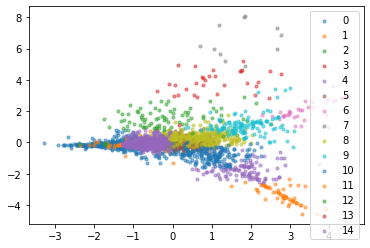

In [25]:
fig, ax = plt.subplots()
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(x_pca[:,0][ix], x_pca[:,1][ix], label = g, s = 10 ,alpha = 0.5)
ax.legend()
plt.show()

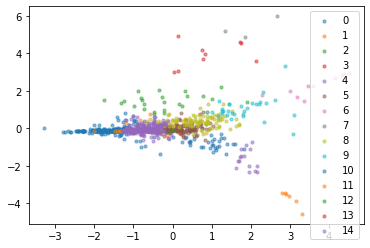

In [26]:
#90s
labels_90 = labels[:866] 
x_pca_90 = x_pca[:866]

fig, ax = plt.subplots()
for g in np.unique(labels_90):
    ix = np.where(labels_90 == g)
    ax.scatter(x_pca_90[:,0][ix], x_pca_90[:,1][ix], label = g, s = 10 ,alpha = 0.5)
ax.legend()
plt.show()

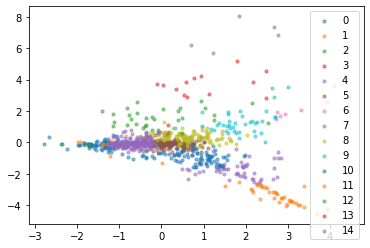

In [27]:
#2010s
labels_10 = labels[1812:] 
x_pca_10 = x_pca[1812:]

fig, ax = plt.subplots()
for g in np.unique(labels_10):
    ix = np.where(labels_10 == g)
    ax.scatter(x_pca_10[:,0][ix], x_pca_10[:,1][ix], label = g, s = 10 ,alpha = 0.5)
ax.legend()
plt.show()